## 互评作业四 离群点分析与异常值检测

github:

使用的benchmark数据集为wive_benchmark和wine_benchmark

由于数据量比较大，因此首先选择了一个数据文件测试不同模型(Angle-Based Outlier Detection， Clustering-Based Local Outlier Factor，Feature Bagging，
Histogram-based Outlier Score，Isolation Forest， Local Outlier Factor, KNN)的检测效果，确定最好效果的模型之后，再将这个模型应用到所有的数据文件上

In [11]:
import pandas as pd
import numpy as np
import random
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from pyod.models.abod import ABOD
from pyod.models.cblof import CBLOF
from pyod.models.feature_bagging import FeatureBagging
from pyod.models.hbos import HBOS
from pyod.models.iforest import IForest
from pyod.models.knn import KNN
from pyod.models.lof import LOF
from pyod.utils.data import generate_data
from pyod.utils.data import evaluate_print
from pyod.utils.example import visualize

In [12]:
# 获取benchmark中所有的csv文件
index_list = list(str(i).zfill(4) for i in range(1, 1640))
filenames = ['wave/benchmarks/wave_benchmark_' + i + '.csv' for i in index_list]

1. 首先选择一个文件测试不同的模型的检测性能

In [13]:
# 首先使用其中一个csv文件中的数据进行测试(使用第一个文件)
data1 = pd.read_csv(filenames[0])
data1.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,V,V.1,V.2,V.3,...,V.11,V.12,V.13,V.14,V.15,V.16,V.17,V.18,V.19,V.20
0,wave_point_0242,wave,multiclass,2,0.001130,nominal,0.440395,-0.293023,-1.374141,-2.382361,...,0.235635,0.581920,0.745048,0.674833,0.397361,0.008963,1.677061,0.800549,-0.441398,-1.583270
1,wave_point_4490,wave,multiclass,0,0.474350,anomaly,0.093905,-0.093717,1.891936,1.002227,...,-0.134625,-1.791554,-0.698042,-0.598220,-0.894968,-0.823398,0.799381,-0.744561,0.418648,-1.613359
2,wave_point_0454,wave,multiclass,2,0.000153,nominal,1.123475,-0.558765,0.688201,-1.336601,...,1.538160,1.629397,1.017757,-0.241567,-0.094166,0.272444,-1.012604,-1.337549,-0.885293,-0.219266
3,wave_point_2033,wave,multiclass,0,0.354121,anomaly,1.301670,-1.479368,-1.087939,-1.025700,...,-0.167684,1.193453,1.012076,2.022189,3.236067,2.170706,0.990489,2.095101,2.767593,1.435593
4,wave_point_2294,wave,multiclass,0,0.349918,anomaly,-0.896067,-0.055754,-0.380850,1.221271,...,-1.536327,-1.500924,-0.976433,-0.261381,-0.342690,-1.571924,-0.403890,-0.569170,-1.181223,-0.640502


In [14]:
# print(data1['V'].describe())
print(data1.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3010 entries, 0 to 3009
Data columns (total 27 columns):
point.id          3010 non-null object
motherset         3010 non-null object
origin            3010 non-null object
original.label    3010 non-null int64
diff.score        3010 non-null float64
ground.truth      3010 non-null object
V                 3010 non-null float64
V.1               3010 non-null float64
V.2               3010 non-null float64
V.3               3010 non-null float64
V.4               3010 non-null float64
V.5               3010 non-null float64
V.6               3010 non-null float64
V.7               3010 non-null float64
V.8               3010 non-null float64
V.9               3010 non-null float64
V.10              3010 non-null float64
V.11              3010 non-null float64
V.12              3010 non-null float64
V.13              3010 non-null float64
V.14              3010 non-null float64
V.15              3010 non-null float64
V.16              3

In [15]:
# 处理训练数据和测试数据 这里划分的比列为4：1
data_X = np.array(data1.iloc[:, 6:])
data_y = np.array([0 if item == 'nominal' else 1 for item in data1['ground.truth']])
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [16]:
#首先使用KNN模型进行测试
clf_name = 'KNN'
clf = KNN()
clf.fit(train_X)

y_train_pred = clf.labels_  
y_train_scores = clf.decision_scores_  

y_test_pred = clf.predict(test_X)  
y_test_scores = clf.decision_function(test_X)  

print("On Training Data:")
evaluate_print(clf_name, train_y, y_train_scores)
print("On Test Data:")
evaluate_print(clf_name, test_y, y_test_scores)

On Training Data:
KNN ROC:0.5445, precision @ rank n:0.3521
On Test Data:
KNN ROC:0.5642, precision @ rank n:0.4031


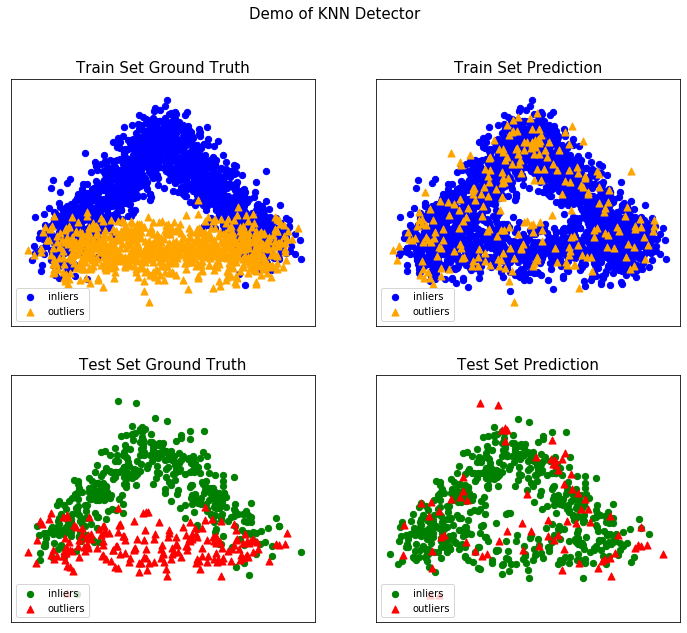

In [17]:
# 为了直观显示 使用了PCA算法先对数据进行了降维 
pca = PCA(n_components=2)
train_X = pca.fit_transform(train_X)
test_X = pca.fit_transform(test_X)
visualize(clf_name, train_X, train_y, test_X, test_y, y_train_pred,
          y_test_pred, show_figure=True, save_figure=True)

使用不同模型进行训练

In [18]:
"""
这里使用了Angle-Based Outlier Detection， Clustering-Based Local Outlier Factor，Feature Bagging，
Histogram-based Outlier Score，Isolation Forest， Local Outlier Factor 加上之前的KNN七种模型进行测试
比较不同模型的性能
"""

clf_names = ['ABOD', 'CBLOF', 'FeatureBagging', 'HBOS', 'IForest', 'LOF']
clf_fun = [ABOD(), CBLOF(), FeatureBagging(), HBOS(), IForest(behaviour="new"), LOF()]

for i in range(len(clf_names)):
    clf_name = clf_names[i]
    clf = clf_fun[i]
    clf.fit(train_X)

    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_  

    y_test_pred = clf.predict(test_X)  
    y_test_scores = clf.decision_function(test_X)  

    print("On Training Data:")
    evaluate_print(clf_name, train_y, y_train_scores)
    print("On Test Data:")
    evaluate_print(clf_name, test_y, y_test_scores)
    print()
    

On Training Data:
ABOD ROC:0.5797, precision @ rank n:0.3908
On Test Data:
ABOD ROC:0.5668, precision @ rank n:0.3979

On Training Data:
CBLOF ROC:0.6788, precision @ rank n:0.5181
On Test Data:
CBLOF ROC:0.672, precision @ rank n:0.4764

On Training Data:
FeatureBagging ROC:0.5169, precision @ rank n:0.3608
On Test Data:
FeatureBagging ROC:0.5471, precision @ rank n:0.3613

On Training Data:
HBOS ROC:0.2614, precision @ rank n:0.2695
On Test Data:
HBOS ROC:0.2964, precision @ rank n:0.32

On Training Data:
IForest ROC:0.5091, precision @ rank n:0.3321
On Test Data:
IForest ROC:0.5704, precision @ rank n:0.4084

On Training Data:
LOF ROC:0.4989, precision @ rank n:0.3383
On Test Data:
LOF ROC:0.5241, precision @ rank n:0.3508



从这七种模型的结果来看，Clustering-Based Local Outlier Factor方式的效果最好，因此，下面对其他数据集的训练都是用CBLOF模型

2.使用Clustering-Based Local Outlier Factor模型依次处理所有的文件

In [25]:
original_data = np.array(pd.read_csv('wave/meta_data/wave.original.csv').iloc[:, 1:])
index_random = np.random.choice
# 如果全部输出实在太长了， 这里仅使用前20个文件做测试
for filename in filenames[:20]:
    outliers_fraction = 0.01
    data = pd.read_csv(filename)
    data_X = np.array(data.iloc[:, 6:])
    data_y = np.array([0 if item == 'nominal' else 1 for item in data['ground.truth']])
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=0)
    
    clf_name = 'ABOD'
    clf = ABOD()
    clf.fit(train_X)

    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_  

    y_test_pred = clf.predict(test_X)  
    y_test_scores = clf.decision_function(test_X)  
    
    outliers = np.count_nonzero(y_test_pred)
    inliers = len(y_test_pred) - outliers

    print(filename)
    evaluate_print('Train data: ', train_y, y_train_scores)
    evaluate_print('Test data: ', test_y, y_test_scores)
    print('Test data count')
    print('Inliers:', inliers, ' Outliers: ', outliers) 
    print()

wave/benchmarks/wave_benchmark_0001.csv
Train data:  ROC:0.522, precision @ rank n:0.3396
Test data:  ROC:0.5289, precision @ rank n:0.3613
Test data count
Inliers: 536  Outliers:  66

wave/benchmarks/wave_benchmark_0002.csv
Train data:  ROC:0.5111, precision @ rank n:0.3643
Test data:  ROC:0.4682, precision @ rank n:0.3147
Test data count
Inliers: 530  Outliers:  72

wave/benchmarks/wave_benchmark_0003.csv
Train data:  ROC:0.5181, precision @ rank n:0.3384
Test data:  ROC:0.5109, precision @ rank n:0.3591
Test data count
Inliers: 543  Outliers:  59

wave/benchmarks/wave_benchmark_0004.csv
Train data:  ROC:0.533, precision @ rank n:0.3548
Test data:  ROC:0.5049, precision @ rank n:0.3457
Test data count
Inliers: 554  Outliers:  48

wave/benchmarks/wave_benchmark_0005.csv
Train data:  ROC:0.5005, precision @ rank n:0.356
Test data:  ROC:0.4635, precision @ rank n:0.3
Test data count
Inliers: 551  Outliers:  51

wave/benchmarks/wave_benchmark_0006.csv
Train data:  ROC:0.4922, precision @

### 2.wine benchmark数据集

In [26]:
# 获取benchmark中所有的csv文件
index_list = list(str(i).zfill(4) for i in range(1, 1680))
filenames = ['wine/benchmarks/wine_benchmark_' + i + '.csv' for i in index_list]

In [40]:
# 首先使用其中一个csv文件中的数据进行测试(使用第一个文件)
data1 = pd.read_csv(filenames[0])
# data1.isnull().any()
data1.head()

,point.id,motherset,origin,original.label,diff.score,ground.truth,fixed.acidity,volatile.acidity,citric.acid,residual.sugar,chlorides,free.sulfur.dioxide,total.sulfur.dioxide,density,pH,sulphates,alcohol
0,wine_point_3594,wine,regression,7,0.050492,nominal,-1.245962,-0.362411,-0.265853,-0.261304,-0.343495,1.209882,0.747594,-0.899276,0.817846,-0.613338,0.174560
1,wine_point_5089,wine,regression,5,0.082237,anomaly,0.759540,0.973867,0.215849,-0.534540,0.598458,-0.536656,0.199134,0.968217,0.071518,0.596292,-0.915394
2,wine_point_1912,wine,regression,6,0.290201,nominal,-0.088942,-0.969809,-0.403482,-0.870829,-0.429127,-0.592996,-0.791633,-0.699187,-1.110168,1.402712,-0.496181
3,wine_point_4908,wine,regression,5,0.053559,anomaly,0.219597,0.973867,0.284664,0.138039,0.427194,-0.762016,-0.243173,1.034913,0.817846,1.805921,0.006874
4,wine_point_2246,wine,regression,7,0.420300,nominal,0.219597,-0.180191,-0.541112,0.348220,-0.714567,-0.142276,0.446826,-0.242318,-0.363840,-1.016548,0.090717


In [41]:
# 处理训练数据和测试数据 这里划分的比列为4：1
data_X = np.array(data1.iloc[:, 6:])
data_y = np.array([0 if item == 'nominal' else 1 for item in data1['ground.truth']])
train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=0)

In [48]:
#首先使用KNN模型进行测试
clf_name = 'KNN'
clf = KNN()
clf.fit(train_X)

y_train_pred = clf.labels_  
y_train_scores = clf.decision_scores_  

y_test_pred = clf.predict(test_X)  
y_test_scores = clf.decision_function(test_X)  

print("On Training Data:")
evaluate_print(clf_name, train_y, y_train_scores)
print("On Test Data:")
evaluate_print(clf_name, test_y, y_test_scores)

On Training Data:
KNN ROC:0.5898, precision @ rank n:0.44
On Test Data:
KNN ROC:0.5263, precision @ rank n:0.3619


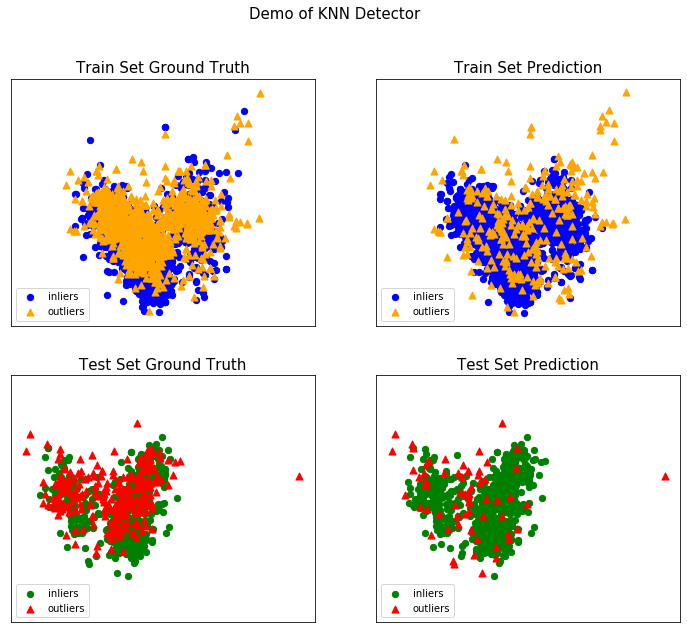

In [43]:
# 为了直观显示 使用了PCA算法先对数据进行了降维 
pca = PCA(n_components=2)
train_X = pca.fit_transform(train_X)
test_X = pca.fit_transform(test_X)
visualize(clf_name, train_X, train_y, test_X, test_y, y_train_pred,
          y_test_pred, show_figure=True, save_figure=True)

In [49]:
"""
这里使用了Clustering-Based Local Outlier Factor，Feature Bagging，
Histogram-based Outlier Score，Isolation Forest， Local Outlier Factor 加上之前的KNN七种模型进行测试
比较不同模型的性能
"""

clf_names = ['CBLOF', 'FeatureBagging', 'HBOS', 'IForest', 'LOF']
clf_fun = [CBLOF(), FeatureBagging(), HBOS(), IForest(behaviour="new"), LOF()]

for i in range(len(clf_names)):
    clf_name = clf_names[i]
    clf = clf_fun[i]
    clf.fit(train_X)

    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_  

    y_test_pred = clf.predict(test_X)  
    y_test_scores = clf.decision_function(test_X)  

    print("On Training Data:")
    evaluate_print(clf_name, train_y, y_train_scores)
    print("On Test Data:")
    evaluate_print(clf_name, test_y, y_test_scores)
    print()

On Training Data:
CBLOF ROC:0.5546, precision @ rank n:0.4193
On Test Data:
CBLOF ROC:0.5238, precision @ rank n:0.3769

On Training Data:
FeatureBagging ROC:0.5559, precision @ rank n:0.425
On Test Data:
FeatureBagging ROC:0.508, precision @ rank n:0.3545

On Training Data:
HBOS ROC:0.5441, precision @ rank n:0.4567
On Test Data:
HBOS ROC:0.4623, precision @ rank n:0.3371

On Training Data:
IForest ROC:0.5714, precision @ rank n:0.4024
On Test Data:
IForest ROC:0.4878, precision @ rank n:0.347

On Training Data:
LOF ROC:0.5475, precision @ rank n:0.4071
On Test Data:
LOF ROC:0.5087, precision @ rank n:0.347



In [51]:
original_data = np.array(pd.read_csv('wave/meta_data/wave.original.csv').iloc[:, 1:])
index_random = np.random.choice
# 如果全部输出实在太长了， 这里仅使用前20个文件做测试
for filename in filenames[:20]:
    outliers_fraction = 0.01
    data = pd.read_csv(filename)
    data_X = np.array(data.iloc[:, 6:])
    data_y = np.array([0 if item == 'nominal' else 1 for item in data['ground.truth']])
    train_X, test_X, train_y, test_y = train_test_split(data_X, data_y, test_size=0.2, random_state=0)
    
    clf_name = 'IForest'
    clf = IForest(behaviour="new")
    clf.fit(train_X)

    y_train_pred = clf.labels_  
    y_train_scores = clf.decision_scores_  

    y_test_pred = clf.predict(test_X)  
    y_test_scores = clf.decision_function(test_X)  
    
    outliers = np.count_nonzero(y_test_pred)
    inliers = len(y_test_pred) - outliers

    print(filename)
    evaluate_print('Train data: ', train_y, y_train_scores)
    evaluate_print('Test data: ', test_y, y_test_scores)
    print('Test data count')
    print('Inliers:', inliers, ' Outliers: ', outliers) 
    print()

wine/benchmarks/wine_benchmark_0001.csv
Train data:  ROC:0.534, precision @ rank n:0.3912
Test data:  ROC:0.5044, precision @ rank n:0.3769
Test data count
Inliers: 678  Outliers:  63

wine/benchmarks/wine_benchmark_0002.csv
Train data:  ROC:0.5498, precision @ rank n:0.3982
Test data:  ROC:0.6221, precision @ rank n:0.4776
Test data count
Inliers: 676  Outliers:  65

wine/benchmarks/wine_benchmark_0003.csv
Train data:  ROC:0.5217, precision @ rank n:0.4006
Test data:  ROC:0.5056, precision @ rank n:0.3485
Test data count
Inliers: 666  Outliers:  75

wine/benchmarks/wine_benchmark_0004.csv
Train data:  ROC:0.5538, precision @ rank n:0.4203
Test data:  ROC:0.5506, precision @ rank n:0.3939
Test data count
Inliers: 658  Outliers:  83

wine/benchmarks/wine_benchmark_0005.csv
Train data:  ROC:0.5447, precision @ rank n:0.4134
Test data:  ROC:0.5287, precision @ rank n:0.3934
Test data count
Inliers: 657  Outliers:  84

wine/benchmarks/wine_benchmark_0006.csv
Train data:  ROC:0.5518, precis